In [1]:
!pip install bertopic -q

In [2]:
!pip install gensim -q

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim import utils
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
pd.options.display.max_rows = 200

In [ ]:
pd.options.display.max_colwidth = 200

In [5]:
df_relevant = pd.read_parquet('drive/MyDrive/NLP/df_relevant.parquet', engine='pyarrow')
df_relevant.shape

(150466, 6)

In [ ]:
df_relevant.columns

Index(['url', 'date', 'language', 'title', 'text', 'text_word_count'], dtype='object')

In [6]:
df_relevant[['title', 'text']].head()

,title,text
0,\r \t\t\t\t\t\t\t\t Artificial intelligence |...,Artificial intelligence Caledon Citizen Member...
1,\r \t\t\r \t\t\tCivilization Call To Power 25t...,Civilization Call To Power 25th Anniversary Ce...
2,\r \t\t AI workshop held at Temple Trees to en...,AI workshop held at Temple Trees to enhance pu...
3,\r \t\tChina’s DeepSeek Breakthrough – and Wha...,China s DeepSeek Breakthrough and What it Mean...
4,"\r \t\tColvin Ph.D. ’99, LaMoreaux ’01 to Disc...","Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impac..."


### Generate Functions for Model Comparisons and Hyperparameter Tuning

In [7]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
class FastTopicModelComparison:
    def __init__(self, df, text_column='text', title_column='title'):
        """Fast topic model comparison for algorithm selection"""
        self.df = df
        self.text_column = text_column
        self.title_column = title_column
        self.results = {}

    def preprocess_text(self, text):
        """Basic text preprocessing"""
        if pd.isna(text):
            return ""
        text = re.sub(r'\s+', ' ', str(text))
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        return text.strip()

    def prepare_documents(self, df=None, combine_title_text=True):
        """Prepare documents for modeling"""
        if df is None:
            df = self.df

        df_copy = df.copy()

        if combine_title_text and self.title_column in df_copy.columns:
            df_copy['processed_title'] = df_copy[self.title_column].apply(self.preprocess_text)
            df_copy['processed_text'] = df_copy[self.text_column].apply(self.preprocess_text)
            df_copy['combined_text'] = df_copy['processed_title'] + '. ' + df_copy['processed_text']
            documents = df_copy['combined_text'].tolist()
        else:
            documents = df_copy[self.text_column].apply(self.preprocess_text).tolist()

        # Filter short documents
        documents = [doc for doc in documents if len(doc.strip()) > 10]
        return documents

    def calculate_simple_coherence(self, documents, topics, topic_words_list):
        """Simplified coherence calculation for speed"""
        try:
            stop_words = set(stopwords.words('english'))
            texts = []

            # Quick tokenization
            for doc in documents[:500]:  # Limit to 500 docs for speed
                tokens = [word.lower() for word in doc.split()
                         if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
                texts.append(tokens)

            if len(texts) == 0 or len(topic_words_list) == 0:
                return 0.0

            dictionary = Dictionary(texts)
            dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=1000)

            # Filter topic words that exist in dictionary
            filtered_topic_words = []
            for words in topic_words_list:
                filtered_words = [word for word in words if word in dictionary.token2id]
                if len(filtered_words) >= 2:
                    filtered_topic_words.append(filtered_words)

            if len(filtered_topic_words) == 0:
                return 0.0

            coherence_model = CoherenceModel(
                topics=filtered_topic_words,
                texts=texts,
                dictionary=dictionary,
                coherence='c_v'
            )

            return coherence_model.get_coherence()

        except Exception as e:
            print(f"Coherence calculation failed: {e}")
            return 0.0

    def test_bertopic(self, documents, n_topics_target=15):
        """Test BERTopic with simple parameters"""
        print("Testing BERTopic...")
        start_time = time.time()

        try:
            # Simple BERTopic model
            model = BERTopic(
                embedding_model=SentenceTransformer('all-MiniLM-L6-v2'),
                umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42),
                hdbscan_model=HDBSCAN(min_cluster_size=15, min_samples=5, metric='euclidean'),
                vectorizer_model=CountVectorizer(max_features=500, stop_words='english', ngram_range=(1, 2)),
                verbose=False
            )

            topics, probabilities = model.fit_transform(documents)

            # Get topic words
            topic_words_list = []
            unique_topics = [t for t in set(topics) if t != -1]
            for topic_id in unique_topics:
                words = [word for word, _ in model.get_topic(topic_id)[:10]]
                topic_words_list.append(words)

            coherence = self.calculate_simple_coherence(documents, topics, topic_words_list)

            result = {
                'model': model,
                'topics': topics,
                'probabilities': probabilities,
                'coherence': coherence,
                'n_topics': len(unique_topics),
                'outlier_pct': (sum(1 for t in topics if t == -1) / len(topics)) * 100,
                'time': time.time() - start_time,
                'topic_words': topic_words_list
            }

            print(f"  Coherence: {coherence:.4f}, Topics: {len(unique_topics)}, Time: {result['time']:.1f}s")
            return result

        except Exception as e:
            print(f"  BERTopic failed: {e}")
            return None

    def test_lda(self, documents, n_topics=15):
        """Test LDA with simple parameters"""
        print("Testing LDA...")
        start_time = time.time()

        try:
            # Vectorize documents
            vectorizer = TfidfVectorizer(
                max_features=500,
                stop_words='english',
                ngram_range=(1, 1),  # Unigrams only for speed
                min_df=2,
                max_df=0.8
            )
            doc_term_matrix = vectorizer.fit_transform(documents)

            # Train LDA
            lda = LatentDirichletAllocation(
                n_components=n_topics,
                random_state=42,
                max_iter=10  # Very fast training
            )
            lda.fit(doc_term_matrix)

            # Get topic assignments
            doc_topics = lda.transform(doc_term_matrix)
            topics = np.argmax(doc_topics, axis=1)

            # Get topic words
            feature_names = vectorizer.get_feature_names_out()
            topic_words_list = []

            for topic_idx in range(n_topics):
                top_words_idx = lda.components_[topic_idx].argsort()[-10:][::-1]
                words = [feature_names[i] for i in top_words_idx]
                topic_words_list.append(words)

            coherence = self.calculate_simple_coherence(documents, topics, topic_words_list)

            result = {
                'model': lda,
                'vectorizer': vectorizer,
                'topics': topics,
                'probabilities': doc_topics,
                'coherence': coherence,
                'n_topics': n_topics,
                'outlier_pct': 0,  # LDA doesn't have outliers
                'time': time.time() - start_time,
                'topic_words': topic_words_list
            }

            print(f"  Coherence: {coherence:.4f}, Topics: {n_topics}, Time: {result['time']:.1f}s")
            return result

        except Exception as e:
            print(f"  LDA failed: {e}")
            return None

    def test_nmf(self, documents, n_topics=15):
        """Test NMF with simple parameters"""
        print("Testing NMF...")
        start_time = time.time()

        try:
            # Vectorize documents
            vectorizer = TfidfVectorizer(
                max_features=500,
                stop_words='english',
                ngram_range=(1, 1),  # Unigrams only for speed
                min_df=2,
                max_df=0.8
            )
            doc_term_matrix = vectorizer.fit_transform(documents)

            # Train NMF
            nmf = NMF(
                n_components=n_topics,
                random_state=42,
                max_iter=50  # Fast training
            )
            doc_topics = nmf.fit_transform(doc_term_matrix)

            # Get topic assignments
            topics = np.argmax(doc_topics, axis=1)
            probabilities = doc_topics / doc_topics.sum(axis=1, keepdims=True)

            # Get topic words
            feature_names = vectorizer.get_feature_names_out()
            topic_words_list = []

            for topic_idx in range(n_topics):
                top_words_idx = nmf.components_[topic_idx].argsort()[-10:][::-1]
                words = [feature_names[i] for i in top_words_idx]
                topic_words_list.append(words)

            coherence = self.calculate_simple_coherence(documents, topics, topic_words_list)

            result = {
                'model': nmf,
                'vectorizer': vectorizer,
                'topics': topics,
                'probabilities': probabilities,
                'coherence': coherence,
                'n_topics': n_topics,
                'outlier_pct': 0,  # NMF doesn't have outliers
                'time': time.time() - start_time,
                'topic_words': topic_words_list
            }

            print(f"  Coherence: {coherence:.4f}, Topics: {n_topics}, Time: {result['time']:.1f}s")
            return result

        except Exception as e:
            print(f"  NMF failed: {e}")
            return None

    def compare_algorithms(self, sample_size=1000):
        """Compare all algorithms on a small sample"""
        print(f"=== Fast Algorithm Comparison on {sample_size} samples ===\n")

        # Sample data
        sample_df = self.df.sample(n=min(sample_size, len(self.df)), random_state=42)
        documents = self.prepare_documents(sample_df)
        print(f"Prepared {len(documents)} documents")

        # Test each algorithm
        algorithms = ['bertopic', 'lda', 'nmf']
        results = {}

        for algorithm in algorithms:
            if algorithm == 'bertopic':
                result = self.test_bertopic(documents)
            elif algorithm == 'lda':
                result = self.test_lda(documents)
            elif algorithm == 'nmf':
                result = self.test_nmf(documents)

            if result:
                results[algorithm] = result

        # Select best algorithm
        if results:
            best_algo = max(results.keys(), key=lambda k: results[k]['coherence'])
            self.results = results

            print(f"\n=== Comparison Results ===")
            for algo, result in results.items():
                marker = " ← BEST" if algo == best_algo else ""
                print(f"{algo.upper()}: Coherence={result['coherence']:.4f}, "
                      f"Topics={result['n_topics']}, Time={result['time']:.1f}s{marker}")

            return best_algo, results
        else:
            raise ValueError("All algorithms failed")

    def visualize_comparison(self):
        """Visualize algorithm comparison results"""
        if not self.results:
            print("No results to visualize")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

        algorithms = list(self.results.keys())
        coherences = [self.results[algo]['coherence'] for algo in algorithms]
        times = [self.results[algo]['time'] for algo in algorithms]
        n_topics = [self.results[algo]['n_topics'] for algo in algorithms]

        # 1. Coherence comparison
        bars1 = ax1.bar(algorithms, coherences, color=['skyblue', 'lightcoral', 'lightgreen'][:len(algorithms)])
        ax1.set_ylabel('Coherence Score')
        ax1.set_title('Algorithm Coherence Comparison')
        for i, v in enumerate(coherences):
            ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 2. Speed comparison
        bars2 = ax2.bar(algorithms, times, color=['skyblue', 'lightcoral', 'lightgreen'][:len(algorithms)])
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('Algorithm Speed Comparison')
        for i, v in enumerate(times):
            ax2.text(i, v + 0.1, f'{v:.1f}s', ha='center', va='bottom')

        # 3. Number of topics
        bars3 = ax3.bar(algorithms, n_topics, color=['skyblue', 'lightcoral', 'lightgreen'][:len(algorithms)])
        ax3.set_ylabel('Number of Topics')
        ax3.set_title('Topics Discovered')
        for i, v in enumerate(n_topics):
            ax3.text(i, v + 0.3, str(v), ha='center', va='bottom')

        # 4. Top words for best model
        best_algo = max(self.results.keys(), key=lambda k: self.results[k]['coherence'])
        topic_words = self.results[best_algo]['topic_words'][:5]  # Top 5 topics

        ax4.axis('off')
        ax4.text(0.1, 0.9, f'Best Model: {best_algo.upper()}',
                transform=ax4.transAxes, fontsize=14, fontweight='bold')

        for i, words in enumerate(topic_words):
            ax4.text(0.1, 0.8 - i*0.15, f'Topic {i}: {", ".join(words[:5])}',
                    transform=ax4.transAxes, fontsize=10)

        plt.tight_layout()
        plt.show()


class OptimalTopicModelTrainer:
    def __init__(self, df, text_column='text', title_column='title', algorithm='bertopic'):
        """Trainer for running the optimal algorithm on full dataset"""
        self.df = df
        self.text_column = text_column
        self.title_column = title_column
        self.algorithm = algorithm
        self.model = None
        self.vectorizer = None
        self.topics = None
        self.probabilities = None

    def preprocess_text(self, text):
        """Basic text preprocessing"""
        if pd.isna(text):
            return ""
        text = re.sub(r'\s+', ' ', str(text))
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        return text.strip()

    def prepare_documents(self, df=None, combine_title_text=True):
        """Prepare documents for modeling"""
        if df is None:
            df = self.df

        df_copy = df.copy()

        if combine_title_text and self.title_column in df_copy.columns:
            print("Preprocessing titles and text...")
            df_copy['processed_title'] = df_copy[self.title_column].apply(self.preprocess_text)
            df_copy['processed_text'] = df_copy[self.text_column].apply(self.preprocess_text)
            df_copy['combined_text'] = df_copy['processed_title'] + '. ' + df_copy['processed_text']
            documents = df_copy['combined_text'].tolist()
        else:
            print("Preprocessing text...")
            documents = df_copy[self.text_column].apply(self.preprocess_text).tolist()

        # Filter short documents
        print("Filtering documents...")
        documents = [doc for doc in documents if len(doc.strip()) > 10]
        print(f"Prepared {len(documents)} valid documents")
        return documents

    def train_bertopic_full(self, documents):
        """Train BERTopic on full dataset with optimized parameters"""
        print("Training BERTopic on full dataset...")

        # Optimized for large datasets
        sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

        umap_model = UMAP(
            n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            random_state=42,
            low_memory=True  # Memory optimization
        )

        hdbscan_model = HDBSCAN(
            min_cluster_size=50,  # Larger for big dataset
            min_samples=10,
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True
        )

        vectorizer_model = CountVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=5  # Higher min_df for large dataset
        )

        self.model = BERTopic(
            embedding_model=sentence_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=True
        )

        self.topics, self.probabilities = self.model.fit_transform(documents)
        return self.model

    def train_lda_full(self, documents, n_topics=20):
        """Train LDA on full dataset"""
        print("Training LDA on full dataset...")

        self.vectorizer = TfidfVectorizer(
            max_features=2000,  # More features for full dataset
            stop_words='english',
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.8
        )

        print("Vectorizing documents...")
        doc_term_matrix = self.vectorizer.fit_transform(documents)

        print("Training LDA model...")
        self.model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=20,  # Reasonable for large dataset
            n_jobs=-1  # Use all CPU cores
        )

        self.model.fit(doc_term_matrix)

        # Get topic assignments
        print("Getting topic assignments...")
        doc_topics = self.model.transform(doc_term_matrix)
        self.topics = np.argmax(doc_topics, axis=1)
        self.probabilities = doc_topics

        return self.model

    def train_nmf_full(self, documents, n_topics=20):
        """Train NMF on full dataset"""
        print("Training NMF on full dataset...")

        self.vectorizer = TfidfVectorizer(
            max_features=2000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.8
        )

        print("Vectorizing documents...")
        doc_term_matrix = self.vectorizer.fit_transform(documents)

        print("Training NMF model...")
        self.model = NMF(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            alpha_W=0.1,
            alpha_H=0.1
        )

        doc_topics = self.model.fit_transform(doc_term_matrix)

        # Get topic assignments
        self.topics = np.argmax(doc_topics, axis=1)
        self.probabilities = doc_topics / doc_topics.sum(axis=1, keepdims=True)

        return self.model

    def train_full_dataset(self, n_topics=20):
        """Train the selected algorithm on full dataset"""
        print(f"\n=== Training {self.algorithm.upper()} on Full Dataset ({len(self.df)} documents) ===")

        documents = self.prepare_documents(combine_title_text=True)
        start_time = time.time()

        if self.algorithm == 'bertopic':
            model = self.train_bertopic_full(documents)
        elif self.algorithm == 'lda':
            model = self.train_lda_full(documents, n_topics)
        elif self.algorithm == 'nmf':
            model = self.train_nmf_full(documents, n_topics)
        else:
            raise ValueError(f"Unknown algorithm: {self.algorithm}")

        training_time = time.time() - start_time

        print(f"\n=== Training Completed ===")
        print(f"Algorithm: {self.algorithm.upper()}")
        print(f"Training time: {training_time/60:.1f} minutes")
        print(f"Topics discovered: {len(set(self.topics)) - (1 if -1 in self.topics else 0)}")
        if -1 in self.topics:
            print(f"Outliers: {sum(1 for t in self.topics if t == -1)} ({sum(1 for t in self.topics if t == -1)/len(self.topics)*100:.1f}%)")

        return model

    def get_topic_info(self, n_words=10):
        """Get topic information from trained model"""
        if self.model is None:
            raise ValueError("Model must be trained first")

        topic_info = []

        if self.algorithm == 'bertopic':
            topic_freq = self.model.get_topic_freq()
            for _, row in topic_freq.iterrows():
                topic_id = row['Topic']
                if topic_id != -1:
                    topic_words = self.model.get_topic(topic_id)[:n_words]
                    words = [word for word, _ in topic_words]

                    topic_info.append({
                        'Topic': topic_id,
                        'Count': row['Count'],
                        'Top_Words': ', '.join(words),
                        'Percentage': (row['Count'] / len(self.topics)) * 100
                    })

        elif self.algorithm in ['lda', 'nmf']:
            feature_names = self.vectorizer.get_feature_names_out()
            unique_topics = sorted(set(self.topics))

            for topic_idx, topic_id in enumerate(unique_topics):
                if topic_idx < self.model.components_.shape[0]:
                    top_words_idx = self.model.components_[topic_idx].argsort()[-n_words:][::-1]
                    words = [feature_names[i] for i in top_words_idx]
                    topic_count = sum(1 for t in self.topics if t == topic_id)

                    topic_info.append({
                        'Topic': topic_id,
                        'Count': topic_count,
                        'Top_Words': ', '.join(words),
                        'Percentage': (topic_count / len(self.topics)) * 100
                    })

        return pd.DataFrame(topic_info)

    def assign_topics_to_dataframe(self, df=None):
        """Assign topics to full dataframe"""
        if self.model is None:
            raise ValueError("Model must be trained first")

        if df is None:
            df = self.df

        print("Assigning topics to full dataset...")
        documents = self.prepare_documents(df, combine_title_text=True)

        # For large datasets, process in chunks
        chunk_size = 10000
        all_topics = []
        all_probabilities = []

        for i in range(0, len(documents), chunk_size):
            chunk_docs = documents[i:i+chunk_size]
            print(f"Processing chunk {i//chunk_size + 1}/{(len(documents)-1)//chunk_size + 1}")

            if self.algorithm == 'bertopic':
                try:
                    chunk_topics, chunk_probs = self.model.transform(chunk_docs)
                except:
                    chunk_topics, chunk_probs = self.model.approximate_distribution(chunk_docs)

            elif self.algorithm in ['lda', 'nmf']:
                chunk_matrix = self.vectorizer.transform(chunk_docs)
                if self.algorithm == 'lda':
                    chunk_probs = self.model.transform(chunk_matrix)
                else:  # NMF
                    chunk_probs = self.model.transform(chunk_matrix)
                    chunk_probs = chunk_probs / chunk_probs.sum(axis=1, keepdims=True)
                chunk_topics = np.argmax(chunk_probs, axis=1)

            all_topics.extend(chunk_topics)
            all_probabilities.extend(chunk_probs)

        # Create result dataframe
        result_df = df.copy()
        result_df['topic'] = all_topics
        result_df['topic_probability'] = [max(prob) if isinstance(prob, (list, np.ndarray)) else prob
                                         for prob in all_probabilities]

        # Add topic labels
        topic_info = self.get_topic_info()
        topic_labels = dict(zip(topic_info['Topic'], topic_info['Top_Words']))
        result_df['topic_label'] = result_df['topic'].map(topic_labels)

        print("Topic assignment completed!")
        return result_df

In [9]:
def fast_algorithm_selection(df_relevant, sample_size=1000):
    """
    Fast algorithm selection on small sample

    Args:
        df_relevant: Your full dataset
        sample_size: Size of sample for testing (recommended: 1000)

    Returns:
        best_algorithm: Name of best performing algorithm
        comparison_results: Detailed results for all algorithms
    """
    print("=== Fast Topic Modeling Algorithm Selection ===\n")

    # Initialize comparison
    comparator = FastTopicModelComparison(df_relevant)

    # Compare algorithms
    best_algorithm, results = comparator.compare_algorithms(sample_size)

    # Visualize results
    comparator.visualize_comparison()

    print(f"\n=== Recommendation ===")
    print(f"Best algorithm for your dataset: {best_algorithm.upper()}")
    print(f"Expected training time on full dataset:")

    # Estimate full dataset training time
    sample_time = results[best_algorithm]['time']
    full_size = len(df_relevant)

    if best_algorithm == 'bertopic':
        estimated_time = (sample_time / sample_size) * full_size * 0.8  # BERTopic scales better
        print(f"  BERTopic: ~{estimated_time/60:.1f} minutes")
    elif best_algorithm == 'lda':
        estimated_time = (sample_time / sample_size) * full_size * 0.6  # LDA scales well
        print(f"  LDA: ~{estimated_time/60:.1f} minutes")
    elif best_algorithm == 'nmf':
        estimated_time = (sample_time / sample_size) * full_size * 0.4  # NMF is fastest
        print(f"  NMF: ~{estimated_time/60:.1f} minutes")

    return best_algorithm, results


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10.5 µs
=== Fast Topic Modeling Algorithm Selection ===

=== Fast Algorithm Comparison on 5000 samples ===

Prepared 5000 documents
Testing BERTopic...
  Coherence: 0.5437, Topics: 78, Time: 59.2s
Testing LDA...
  Coherence: 0.5662, Topics: 15, Time: 18.2s
Testing NMF...
  Coherence: 0.6267, Topics: 15, Time: 6.6s

=== Comparison Results ===
BERTOPIC: Coherence=0.5437, Topics=78, Time=59.2s
LDA: Coherence=0.5662, Topics=15, Time=18.2s
NMF: Coherence=0.6267, Topics=15, Time=6.6s ← BEST


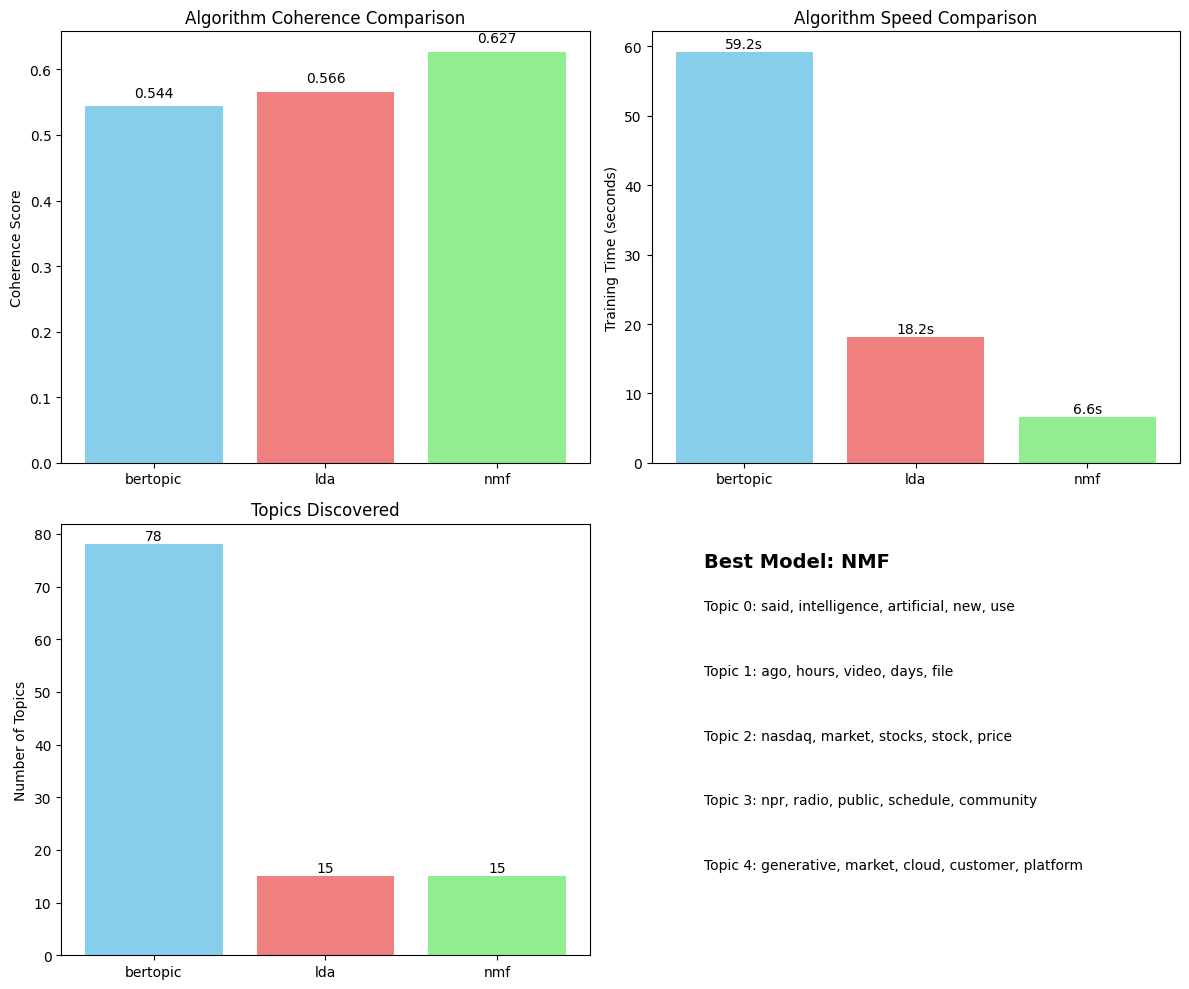


=== Recommendation ===
Best algorithm for your dataset: NMF
Expected training time on full dataset:
  NMF: ~1.3 minutes


In [14]:
%time
# Test 3 algorithms on 5000 random samples
best_algorithm, comparison_results = fast_algorithm_selection(df_relevant, sample_size=5000)

## Full Dataset Training on the Winning Model

In [19]:
class ImprovedTopicModelTrainer:
    def __init__(self, df, text_column='text', title_column='title', algorithm='nmf'):
        """Improved trainer with automatic topic number selection"""
        self.df = df
        self.text_column = text_column
        self.title_column = title_column
        self.algorithm = algorithm
        self.model = None
        self.vectorizer = None
        self.topics = None
        self.probabilities = None
        self.optimal_n_topics = None

    def preprocess_text(self, text):
        """Basic text preprocessing"""
        if pd.isna(text):
            return ""
        text = re.sub(r'\s+', ' ', str(text))
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        return text.strip()

    def prepare_documents(self, df=None, combine_title_text=True):
        """Prepare documents for modeling"""
        if df is None:
            df = self.df

        df_copy = df.copy()

        if combine_title_text and self.title_column in df_copy.columns:
            print("Preprocessing titles and text...")
            df_copy['processed_title'] = df_copy[self.title_column].apply(self.preprocess_text)
            df_copy['processed_text'] = df_copy[self.text_column].apply(self.preprocess_text)
            df_copy['combined_text'] = df_copy['processed_title'] + '. ' + df_copy['processed_text']
            documents = df_copy['combined_text'].tolist()
        else:
            print("Preprocessing text...")
            documents = df_copy[self.text_column].apply(self.preprocess_text).tolist()

        # Filter short documents
        documents = [doc for doc in documents if len(doc.strip()) > 10]
        return documents

    def find_optimal_n_topics(self, documents, algorithm='nmf', max_topics=50, min_topics=5):
        """
        Find optimal number of topics using coherence and silhouette analysis
        Tests on a subset for speed, then validates the choice
        """
        print(f"\n=== Finding Optimal Number of Topics for {algorithm.upper()} ===")

        # Use subset for topic number optimization (much faster)
        sample_docs = documents[:2000] if len(documents) > 2000 else documents
        print(f"Testing topic numbers on {len(sample_docs)} documents...")

        # Test range of topic numbers
        topic_range = range(min_topics, min(max_topics + 1, len(sample_docs) // 50))
        coherence_scores = []
        silhouette_scores = []

        print("Testing topic numbers:", end=" ")

        for n_topics in topic_range:
            print(f"{n_topics}", end=" ")

            try:
                if algorithm == 'nmf':
                    # Improved NMF parameters
                    vectorizer = TfidfVectorizer(
                        max_features=3000,
                        stop_words='english',
                        ngram_range=(1, 2),
                        min_df=max(2, len(sample_docs) // 1000),  # Adaptive min_df
                        max_df=0.7,
                        sublinear_tf=True  # Important for large datasets
                    )
                    doc_term_matrix = vectorizer.fit_transform(sample_docs)

                    nmf = NMF(
                        n_components=n_topics,
                        random_state=42,
                        max_iter=200,  # More iterations for stability
                        alpha_W=0.1,
                        alpha_H=0.1,
                        l1_ratio=0.5,
                        init='nndsvda'  # Better initialization
                    )
                    doc_topics = nmf.fit_transform(doc_term_matrix)

                elif algorithm == 'lda':
                    vectorizer = TfidfVectorizer(
                        max_features=3000,
                        stop_words='english',
                        ngram_range=(1, 1),
                        min_df=max(2, len(sample_docs) // 1000),
                        max_df=0.7
                    )
                    doc_term_matrix = vectorizer.fit_transform(sample_docs)

                    lda = LatentDirichletAllocation(
                        n_components=n_topics,
                        random_state=42,
                        max_iter=50,
                        learning_method='batch'
                    )
                    lda.fit(doc_term_matrix)
                    doc_topics = lda.transform(doc_term_matrix)

                # Get topic assignments
                topics = np.argmax(doc_topics, axis=1)

                # Calculate coherence (simplified)
                coherence = self.calculate_fast_coherence(sample_docs, topics, vectorizer,
                                                        nmf if algorithm == 'nmf' else lda, n_topics)
                coherence_scores.append(coherence)

                # Calculate silhouette score if we have enough distinct topics
                if len(set(topics)) > 1 and doc_topics.shape[1] > 1:
                    sil_score = silhouette_score(doc_topics, topics)
                    silhouette_scores.append(sil_score)
                else:
                    silhouette_scores.append(0)

            except Exception as e:
                print(f"Error with {n_topics} topics: {e}")
                coherence_scores.append(0)
                silhouette_scores.append(0)

        print()  # New line

        # Find optimal number using elbow method and peak coherence
        coherence_scores = np.array(coherence_scores)
        silhouette_scores = np.array(silhouette_scores)

        # Combine scores (weighted towards coherence)
        combined_scores = 0.7 * coherence_scores + 0.3 * silhouette_scores

        # Find optimal n_topics
        optimal_idx = np.argmax(combined_scores)
        optimal_n_topics = list(topic_range)[optimal_idx]

        # Visualize the selection process
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(topic_range, coherence_scores, 'b-o', label='Coherence')
        plt.plot(topic_range, silhouette_scores, 'r-s', label='Silhouette')
        plt.plot(topic_range, combined_scores, 'g-^', label='Combined', linewidth=2)
        plt.axvline(x=optimal_n_topics, color='orange', linestyle='--', label=f'Optimal: {optimal_n_topics}')
        plt.xlabel('Number of Topics')
        plt.ylabel('Score')
        plt.title('Topic Number Optimization')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        # Show score breakdown
        scores_df = pd.DataFrame({
            'n_topics': list(topic_range),
            'coherence': coherence_scores,
            'silhouette': silhouette_scores,
            'combined': combined_scores
        })
        top_5 = scores_df.nlargest(5, 'combined')

        plt.bar(range(len(top_5)), top_5['combined'], color='lightblue')
        plt.xlabel('Rank')
        plt.ylabel('Combined Score')
        plt.title('Top 5 Topic Numbers')
        plt.xticks(range(len(top_5)), [f"{int(n)}" for n in top_5['n_topics']])

        for i, (idx, row) in enumerate(top_5.iterrows()):
            plt.text(i, row['combined'] + 0.01, f"{int(row['n_topics'])}",
                    ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"\n=== Optimal Topic Number Selection ===")
        print(f"Optimal number of topics: {optimal_n_topics}")
        print(f"Coherence score: {coherence_scores[optimal_idx]:.4f}")
        print(f"Silhouette score: {silhouette_scores[optimal_idx]:.4f}")
        print(f"Combined score: {combined_scores[optimal_idx]:.4f}")

        # Show top 5 alternatives
        print(f"\nTop 5 alternatives:")
        for i, (_, row) in enumerate(top_5.iterrows()):
            marker = " ← SELECTED" if int(row['n_topics']) == optimal_n_topics else ""
            print(f"  {int(row['n_topics'])} topics: Combined={row['combined']:.4f}{marker}")

        self.optimal_n_topics = optimal_n_topics
        return optimal_n_topics, coherence_scores, silhouette_scores

    def calculate_fast_coherence(self, documents, topics, vectorizer, model, n_topics):
        """Fast coherence calculation"""
        try:
            # Get top words for each topic
            feature_names = vectorizer.get_feature_names_out()
            topic_words_list = []

            for topic_idx in range(n_topics):
                if hasattr(model, 'components_'):
                    top_words_idx = model.components_[topic_idx].argsort()[-10:][::-1]
                    words = [feature_names[i] for i in top_words_idx if feature_names[i].isalpha()]
                    topic_words_list.append(words[:8])  # Top 8 words

            # Quick coherence calculation
            stop_words = set(stopwords.words('english'))
            texts = []

            # Process subset of documents for speed
            for doc in documents[:300]:
                tokens = [word.lower() for word in doc.split()
                         if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
                texts.append(tokens)

            if len(texts) == 0 or len(topic_words_list) == 0:
                return 0.0

            dictionary = Dictionary(texts)
            dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=500)

            # Filter topic words
            filtered_topic_words = []
            for words in topic_words_list:
                filtered_words = [word for word in words if word in dictionary.token2id]
                if len(filtered_words) >= 2:
                    filtered_topic_words.append(filtered_words)

            if len(filtered_topic_words) == 0:
                return 0.0

            coherence_model = CoherenceModel(
                topics=filtered_topic_words,
                texts=texts,
                dictionary=dictionary,
                coherence='c_v'
            )

            return coherence_model.get_coherence()

        except Exception as e:
            return 0.0

    def train_improved_nmf(self, documents, n_topics):
        """Train NMF with improved parameters for large datasets"""
        print(f"Training improved NMF with {n_topics} topics...")

        # Improved vectorizer for large datasets
        self.vectorizer = TfidfVectorizer(
            max_features=5000,  # More features for full dataset
            stop_words='english',
            ngram_range=(1, 2),
            min_df=max(3, len(documents) // 10000),  # Adaptive min_df: 3 or 0.01% of docs
            max_df=0.6,  # Lower max_df to filter very common words
            sublinear_tf=True,  # Important for large datasets
            norm='l2'  # L2 normalization
        )

        print("Vectorizing documents...")
        doc_term_matrix = self.vectorizer.fit_transform(documents)
        print(f"Document-term matrix shape: {doc_term_matrix.shape}")
        print(f"Matrix sparsity: {(1 - doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1])) * 100:.1f}%")

        # Improved NMF model
        print("Training NMF model...")
        self.model = NMF(
            n_components=n_topics,
            random_state=42,
            max_iter=300,  # More iterations for stability
            alpha_W=0.01,  # Lower regularization
            alpha_H=0.01,
            l1_ratio=0.1,  # More L2 regularization
            init='nndsvda',  # Better initialization
            solver='mu',  # More stable solver for large data
            beta_loss='frobenius'
        )

        doc_topics = self.model.fit_transform(doc_term_matrix)

        # Get topic assignments
        self.topics = np.argmax(doc_topics, axis=1)
        self.probabilities = doc_topics / doc_topics.sum(axis=1, keepdims=True)

        # Verify we got the expected number of topics
        unique_topics = len(set(self.topics))
        print(f"Topics discovered: {unique_topics}")

        if unique_topics < n_topics * 0.7:  # If we got significantly fewer topics
            print(f"Warning: Only {unique_topics} distinct topics found (expected {n_topics})")
            print("This might indicate:")
            print("  - Documents are very similar")
            print("  - Need different preprocessing")
            print("  - Should try a different algorithm")

        return self.model

    def train_improved_lda(self, documents, n_topics):
        """Train LDA with improved parameters"""
        print(f"Training improved LDA with {n_topics} topics...")

        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            ngram_range=(1, 1),  # LDA works better with unigrams
            min_df=max(3, len(documents) // 10000),
            max_df=0.6,
            sublinear_tf=True
        )

        print("Vectorizing documents...")
        doc_term_matrix = self.vectorizer.fit_transform(documents)
        print(f"Document-term matrix shape: {doc_term_matrix.shape}")

        print("Training LDA model...")
        self.model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=50,
            learning_method='batch',
            n_jobs=-1,
            doc_topic_prior=50/n_topics,  # Alpha = 50/K (common heuristic)
            topic_word_prior=0.01  # Beta = 0.01
        )

        self.model.fit(doc_term_matrix)

        # Get topic assignments
        doc_topics = self.model.transform(doc_term_matrix)
        self.topics = np.argmax(doc_topics, axis=1)
        self.probabilities = doc_topics

        unique_topics = len(set(self.topics))
        print(f"Topics discovered: {unique_topics}")

        return self.model

    def train_improved_bertopic(self, documents):
        """Train BERTopic with parameters optimized for large datasets"""
        print("Training improved BERTopic...")

        # Optimized BERTopic for large datasets
        sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

        umap_model = UMAP(
            n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            random_state=42,
            low_memory=True
        )

        # Adaptive cluster size based on dataset size
        min_cluster_size = max(20, len(documents) // 2000)  # Larger clusters for big datasets

        hdbscan_model = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=max(5, min_cluster_size // 4),
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True
        )

        vectorizer_model = CountVectorizer(
            max_features=2000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=max(3, len(documents) // 10000)
        )

        self.model = BERTopic(
            embedding_model=sentence_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=True
        )

        self.topics, self.probabilities = self.model.fit_transform(documents)

        unique_topics = len(set(self.topics)) - (1 if -1 in self.topics else 0)
        print(f"Topics discovered: {unique_topics}")

        return self.model

    def get_topic_info(self, n_words=10):
        """Get topic information"""
        if self.model is None:
            raise ValueError("Model must be trained first")

        topic_info = []

        if self.algorithm == 'bertopic':
            topic_freq = self.model.get_topic_freq()
            for _, row in topic_freq.iterrows():
                topic_id = row['Topic']
                if topic_id != -1:
                    topic_words = self.model.get_topic(topic_id)[:n_words]
                    words = [word for word, _ in topic_words]

                    topic_info.append({
                        'Topic': topic_id,
                        'Count': row['Count'],
                        'Top_Words': ', '.join(words),
                        'Percentage': (row['Count'] / len(self.topics)) * 100
                    })

        elif self.algorithm in ['lda', 'nmf']:
            feature_names = self.vectorizer.get_feature_names_out()
            unique_topics = sorted(set(self.topics))

            for topic_idx, topic_id in enumerate(unique_topics):
                if topic_idx < self.model.components_.shape[0]:
                    top_words_idx = self.model.components_[topic_idx].argsort()[-n_words:][::-1]
                    words = [feature_names[i] for i in top_words_idx]
                    topic_count = sum(1 for t in self.topics if t == topic_id)

                    topic_info.append({
                        'Topic': topic_id,
                        'Count': topic_count,
                        'Top_Words': ', '.join(words),
                        'Percentage': (topic_count / len(self.topics)) * 100
                    })

        return pd.DataFrame(topic_info)


In [20]:
def find_optimal_topics_and_train(df_relevant, algorithm='nmf', test_sample_size=1000):
    """
    Complete workflow: find optimal topic number, then train on full dataset

    Args:
        df_relevant: Your full dataset
        algorithm: 'nmf', 'lda', or 'bertopic'
        test_sample_size: Size of sample for topic number optimization

    Returns:
        trainer: Trained model
        topic_info: Topic information DataFrame
        optimal_n_topics: The optimal number of topics found
    """

    print(f"=== Complete Workflow for {algorithm.upper()} ===\n")

    # Step 1: Find optimal number of topics on sample
    if algorithm in ['nmf', 'lda']:
        print(f"Step 1: Finding optimal topic number using {test_sample_size} samples...")

        # Sample for topic optimization
        sample_df = df_relevant.sample(n=min(test_sample_size, len(df_relevant)), random_state=42)
        trainer_sample = ImprovedTopicModelTrainer(sample_df, algorithm=algorithm)
        sample_docs = trainer_sample.prepare_documents()

        # Find optimal n_topics
        optimal_n_topics, coherence_scores, silhouette_scores = trainer_sample.find_optimal_n_topics(
            sample_docs, algorithm=algorithm, max_topics=40, min_topics=8
        )

    else:  # BERTopic determines topics automatically
        optimal_n_topics = None
        print("Step 1: BERTopic will automatically determine topic numbers...")

    # Step 2: Train on full dataset
    print(f"\nStep 2: Training {algorithm.upper()} on full dataset...")
    trainer_full = ImprovedTopicModelTrainer(df_relevant, algorithm=algorithm)
    documents_full = trainer_full.prepare_documents()

    start_time = time.time()

    if algorithm == 'nmf':
        model = trainer_full.train_improved_nmf(documents_full, optimal_n_topics)
    elif algorithm == 'lda':
        model = trainer_full.train_improved_lda(documents_full, optimal_n_topics)
    elif algorithm == 'bertopic':
        model = trainer_full.train_improved_bertopic(documents_full)
        optimal_n_topics = len(set(trainer_full.topics)) - (1 if -1 in trainer_full.topics else 0)

    training_time = time.time() - start_time

    # Get results
    topic_info = trainer_full.get_topic_info()

    print(f"\n=== Training Complete ===")
    print(f"Training time: {training_time/60:.1f} minutes")
    print(f"Final topics: {len(topic_info)}")
    print(f"Optimal n_topics used: {optimal_n_topics}")

    # Show topic summary
    print(f"\n=== Topic Summary ===")
    print(topic_info[['Topic', 'Count', 'Percentage', 'Top_Words']].head(10))

    return trainer_full, topic_info, optimal_n_topics


In [21]:
def assign_topics_to_full_dataframe(trainer, df_relevant, chunk_size=5000):
    """
    Efficiently assign topics to the full dataframe in chunks

    Args:
        trainer: Trained topic model
        df_relevant: Your full dataset
        chunk_size: Process in chunks to manage memory

    Returns:
        df_with_topics: DataFrame with topic assignments
    """
    print(f"\n=== Assigning Topics to Full Dataset ({len(df_relevant)} rows) ===")

    # Process in chunks for memory efficiency
    results_list = []
    total_chunks = (len(df_relevant) - 1) // chunk_size + 1

    for i in range(0, len(df_relevant), chunk_size):
        chunk_df = df_relevant.iloc[i:i+chunk_size].copy()
        chunk_docs = trainer.prepare_documents(chunk_df)

        print(f"Processing chunk {i//chunk_size + 1}/{total_chunks} ({len(chunk_docs)} docs)")

        if trainer.algorithm == 'bertopic':
            try:
                chunk_topics, chunk_probs = trainer.model.transform(chunk_docs)
            except:
                chunk_topics, chunk_probs = trainer.model.approximate_distribution(chunk_docs)

        elif trainer.algorithm in ['lda', 'nmf']:
            chunk_matrix = trainer.vectorizer.transform(chunk_docs)
            chunk_probs = trainer.model.transform(chunk_matrix)
            if trainer.algorithm == 'nmf':
                chunk_probs = chunk_probs / chunk_probs.sum(axis=1, keepdims=True)
            chunk_topics = np.argmax(chunk_probs, axis=1)

        # Add to chunk dataframe
        chunk_df['topic'] = chunk_topics
        chunk_df['topic_probability'] = [max(prob) if isinstance(prob, (list, np.ndarray)) else prob
                                        for prob in chunk_probs]

        results_list.append(chunk_df)

    # Combine all chunks
    df_with_topics = pd.concat(results_list, ignore_index=True)

    # Add topic labels
    topic_info = trainer.get_topic_info()
    topic_labels = dict(zip(topic_info['Topic'], topic_info['Top_Words']))

    # Handle outliers for BERTopic
    if -1 in df_with_topics['topic'].values:
        topic_labels[-1] = 'Outlier'

    df_with_topics['topic_label'] = df_with_topics['topic'].map(topic_labels)

    print("Topic assignment completed!")
    print(f"Result shape: {df_with_topics.shape}")

    return df_with_topics

=== Complete Workflow for NMF ===

Step 1: Finding optimal topic number using 1000 samples...
Preprocessing titles and text...

=== Finding Optimal Number of Topics for NMF ===
Testing topic numbers on 1000 documents...
Testing topic numbers: 8 9 10 11 12 13 14 15 16 17 18 19 


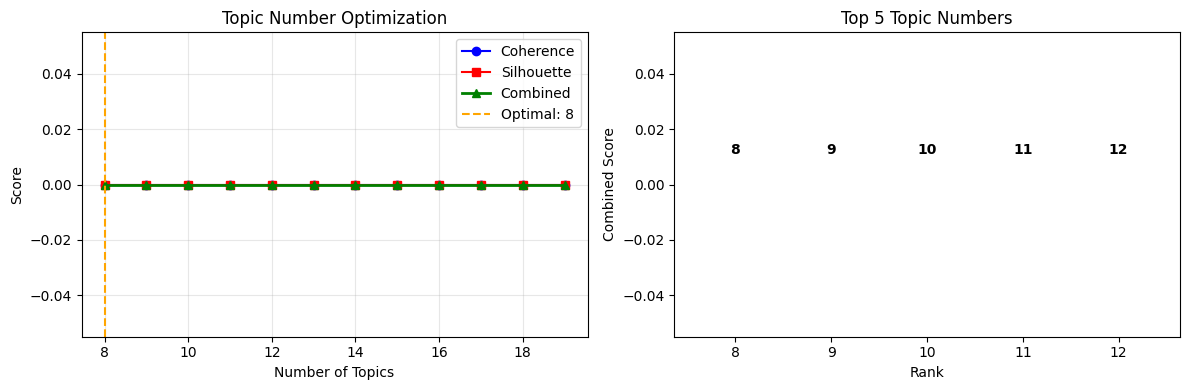


=== Optimal Topic Number Selection ===
Optimal number of topics: 8
Coherence score: 0.0000
Silhouette score: 0.0000
Combined score: 0.0000

Top 5 alternatives:
  8 topics: Combined=0.0000 ← SELECTED
  9 topics: Combined=0.0000
  10 topics: Combined=0.0000
  11 topics: Combined=0.0000
  12 topics: Combined=0.0000

Step 2: Training NMF on full dataset...
Preprocessing titles and text...
Training improved NMF with 8 topics...
Vectorizing documents...
Document-term matrix shape: (150466, 5000)
Matrix sparsity: 94.6%
Training NMF model...
Topics discovered: 1
This might indicate:
  - Documents are very similar
  - Need different preprocessing
  - Should try a different algorithm

=== Training Complete ===
Training time: 5.3 minutes
Final topics: 1
Optimal n_topics used: 8

=== Topic Summary ===
   Topic   Count  Percentage  \
0      0  150466       100.0   

                                           Top_Words  
0  00, zuckerberg, zu, zoom, zone, zimbabwe, zero...  


In [22]:
# Step 1: Find optimal topics and train
trainer, topic_info, optimal_n_topics = find_optimal_topics_and_train(
    df_relevant,
    algorithm='nmf',  # or 'lda' or 'bertopic'
    test_sample_size=1000
)

In [23]:
# Step 2: Assign topics to full dataset (5-10 minutes)
df_with_topics = assign_topics_to_full_dataframe(trainer, df_relevant)



=== Assigning Topics to Full Dataset (150466 rows) ===
Preprocessing titles and text...
Processing chunk 1/31 (5000 docs)


ValueError: Array passed to NMF (input H) is full of zeros.

In [ ]:
# Step 3: Analyze results
print("\\nFinal Results:")
print(f"Optimal number of topics: {optimal_n_topics}")
print(f"Topic distribution:")
print(df_with_topics['topic'].value_counts().head(10))

In [18]:
# Analyze results
print("\\n=== Analysis Complete ===")
print(f"Best algorithm: {best_algorithm}")
print(f"Number of topics: {len(topic_info)}")
print(f"Dataset with topic assignments shape: {df_with_topics.shape}")

# Access topic assignments
print("\\nSample topic assignments:")
print(df_with_topics[['title', 'topic', 'topic_label', 'topic_probability']].head())

\n=== Analysis Complete ===
Best algorithm: nmf
Number of topics: 2
Dataset with topic assignments shape: (150466, 9)
\nSample topic assignments:
                                               title  topic  \
0  \r \t\t\t\t\t\t\t\t  Artificial intelligence |...     19   
1  \r \t\t\r \t\t\tCivilization Call To Power 25t...     19   
2  \r \t\t AI workshop held at Temple Trees to en...     19   
3  \r \t\tChina’s DeepSeek Breakthrough – and Wha...     19   
4  \r \t\tColvin Ph.D. ’99, LaMoreaux ’01 to Disc...     19   

                                         topic_label  topic_probability  
0  ago, new, data, 2023, chatgpt, openai, said, 2...           0.099707  
1  ago, new, data, 2023, chatgpt, openai, said, 2...           0.099810  
2  ago, new, data, 2023, chatgpt, openai, said, 2...           0.099783  
3  ago, new, data, 2023, chatgpt, openai, said, 2...           0.099668  
4  ago, new, data, 2023, chatgpt, openai, said, 2...           0.099660  


In [ ]:
def run_enhanced_bertopic_workflow(df_relevant, sample_size=100, test_run=True, algorithms=['bertopic', 'lda']):
    """
    Enhanced workflow with multiple algorithms and hyperparameter tuning
    """
    print("=== Enhanced BERTopic Modeling Workflow ===\n")

    # Initialize enhanced trainer
    trainer = EnhancedBERTopicModelTrainer(df_relevant)

    # Split the full dataset first
    train_df, val_df, test_df = trainer.split_data(test_size=0.2, val_size=0.1)

    if test_run:
        print(f"\n=== TEST RUN: Using sample of {sample_size} documents ===")
        if len(train_df) > sample_size:
            sample_df = train_df.sample(n=sample_size, random_state=42)
        else:
            sample_df = train_df

        trainer.df = sample_df
        documents = trainer.prepare_documents(combine_title_text=True)
        print(f"Prepared {len(documents)} documents for modeling")

        # Train multiple algorithms with hyperparameter tuning
        results = trainer.fit(documents, algorithms=algorithms)

        # Display results
        print(f"\n=== Algorithm Comparison Results ===")
        for algo_name, algo_result in results.items():
            print(f"{algo_name.upper()}: Score = {algo_result['score']:.4f}, "
                  f"Topics = {len(set(algo_result['topics'])) - (1 if -1 in algo_result['topics'] else 0)}")

        # Get topic information
        topic_info = trainer.get_topic_info()
        print(f"\n=== Top 5 Topics (Best Model: {trainer.best_model_name.upper()}) ===")
        print(topic_info.head()[['Topic', 'Count', 'Percentage', 'Top_Words', 'Algorithm']])

        # Visualize results
        trainer.visualize_topics(top_n_topics=min(10, len(set(trainer.topics))))

        return trainer, results, topic_info

    else:
        print(f"\n=== FULL RUN: Using complete training set ({len(train_df)} documents) ===")
        trainer.df = train_df
        documents = trainer.prepare_documents(combine_title_text=True)
        print(f"Prepared {len(documents)} documents for modeling")

        # Train multiple algorithms
        results = trainer.fit(documents, algorithms=algorithms)

        # Evaluate on validation set
        print(f"\n=== Validation Set Evaluation ===")
        val_trainer = EnhancedBERTopicModelTrainer(val_df)
        val_documents = val_trainer.prepare_documents(combine_title_text=True)
        val_topics, val_probabilities = trainer.predict_topics(val_documents)

        val_metrics = trainer.evaluate_model_performance(val_documents, val_topics)
        print(f"Best model ({trainer.best_model_name}) validation coherence: {val_metrics['coherence_score']:.4f}")

        # Final evaluation on test set
        print(f"\n=== Test Set Evaluation (Final Performance) ===")
        test_trainer = EnhancedBERTopicModelTrainer(test_df)
        test_documents = test_trainer.prepare_documents(combine_title_text=True)
        test_topics, test_probabilities = trainer.predict_topics(test_documents)

        test_metrics = trainer.evaluate_model_performance(test_documents, test_topics)
        print(f"Final test coherence: {test_metrics['coherence_score']:.4f}")

        # Get comprehensive topic information
        topic_info = trainer.get_topic_info()
        print(f"\n=== Final Topic Summary (Best Model: {trainer.best_model_name.upper()}) ===")
        print(topic_info[['Topic', 'Count', 'Percentage', 'Top_Words', 'Algorithm']])

        # Assign topics to my articles
        if trainer is not None:
            df_with_topics = trainer.assign_topics_to_dataframe(
                df_relevant,
                text_column='text',
                title_column='title',
                combine_title_text=False
            )

        # Save the resolved DataFrame to a CSV file
        df_with_topics.to_csv('df_with_topics.csv', index=False)

        # Provide a link to download the file
        from google.colab import files
        files.download('df_with_topics.csv')

        # Visualize results
        trainer.visualize_topics()

        return trainer, {
            'train': results,
            'val': val_metrics,
            'test': test_metrics
        }, topic_info

In [ ]:
# Run with 2000 sample
trainer, results, topic_info = run_enhanced_bertopic_workflow(
    df_relevant,
    sample_size=2000,
    test_run=True,
    algorithms=['bertopic', 'lda', 'nmf']
)

=== Enhanced BERTopic Modeling Workflow ===

Data split completed:
Training set: 108334 samples
Validation set: 12038 samples
Test set: 30094 samples

=== TEST RUN: Using sample of 2000 documents ===
Prepared 2000 documents for modeling
=== Training Multiple Topic Modeling Algorithms ===

--- Training BERTOPIC ---

=== Hyperparameter Tuning for BERTOPIC ===
Testing 6 parameter combinations...
  1/6: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 15, 'min_samples': 3}


KeyboardInterrupt: 

In [ ]:
# After testing, run on full dataset
if trainer.best_score > 0.4:  # Good coherence threshold
    trainer_full, metrics_full, topic_info_full = run_enhanced_bertopic_workflow(
        df_relevant,
        test_run=False,
        algorithms=['bertopic', 'lda', 'nmf']
    )

=== Enhanced BERTopic Modeling Workflow ===

Data split completed:
Training set: 108334 samples
Validation set: 12038 samples
Test set: 30094 samples

=== FULL RUN: Using complete training set (108334 documents) ===
Prepared 108334 documents for modeling
=== Training Multiple Topic Modeling Algorithms ===

--- Training BERTOPIC ---

=== Hyperparameter Tuning for BERTOPIC ===
Testing 6 parameter combinations...
  1/6: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 15, 'min_samples': 3}
    Coherence: 0.5186
  2/6: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 15, 'min_samples': 5}


In [ ]:
import pickle
import json

# Save trainer_full object using pickle
with open('bertopic_trainer_full.pkl', 'wb') as f:
    pickle.dump(trainer_full, f)

# Save metrics_full dictionary using json
with open('bertopic_metrics_full.json', 'w') as f:
    json.dump(metrics_full, f)

# Save topic_info_full DataFrame using csv
topic_info_full.to_csv('bertopic_topic_info_full.csv')

print("Full model results saved successfully!")

# Provide links to download the files
from google.colab import files
files.download('bertopic_trainer_full.pkl')
files.download('bertopic_metrics_full.json')
files.download('bertopic_topic_info_full.csv')

## Visualization of Topics

=== BERTopic Modeling Workflow ===

Data split completed:
Training set: 108334 samples
Validation set: 12038 samples
Test set: 30094 samples

=== TEST RUN: Using sample of 50 documents ===
Prepared 50 documents for modeling


2025-08-05 03:04:30,185 - BERTopic - Embedding - Transforming documents to embeddings.


Training BERTopic model on 50 documents...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:04:35,746 - BERTopic - Embedding - Completed ✓
2025-08-05 03:04:35,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-05 03:04:35,846 - BERTopic - Dimensionality - Completed ✓
2025-08-05 03:04:35,847 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-05 03:04:35,856 - BERTopic - Cluster - Completed ✓
2025-08-05 03:04:35,860 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-05 03:04:36,016 - BERTopic - Representation - Completed ✓


Model training completed!
Number of topics discovered: 2
Number of outliers: 7

=== Model Evaluation Metrics ===
coherence_score: 0.4188 (higher is better, range: 0-1)
calinski_harabasz_score: 2.659
davies_bouldin_score: 3.915
num_topics: 2
outlier_percentage: 14.000
largest_topic_size: 22

=== Top 5 Topics ===
   Topic  Count  Percentage  \
0      0     22        44.0   
1      1     21        42.0   

                                                                                    Top_Words  
0  ai, new, data, media, shipping, 00, science, services, artificial intelligence, artificial  
1                             ai, market, vote, 2024, apple, report, arrow, oil, new, content  


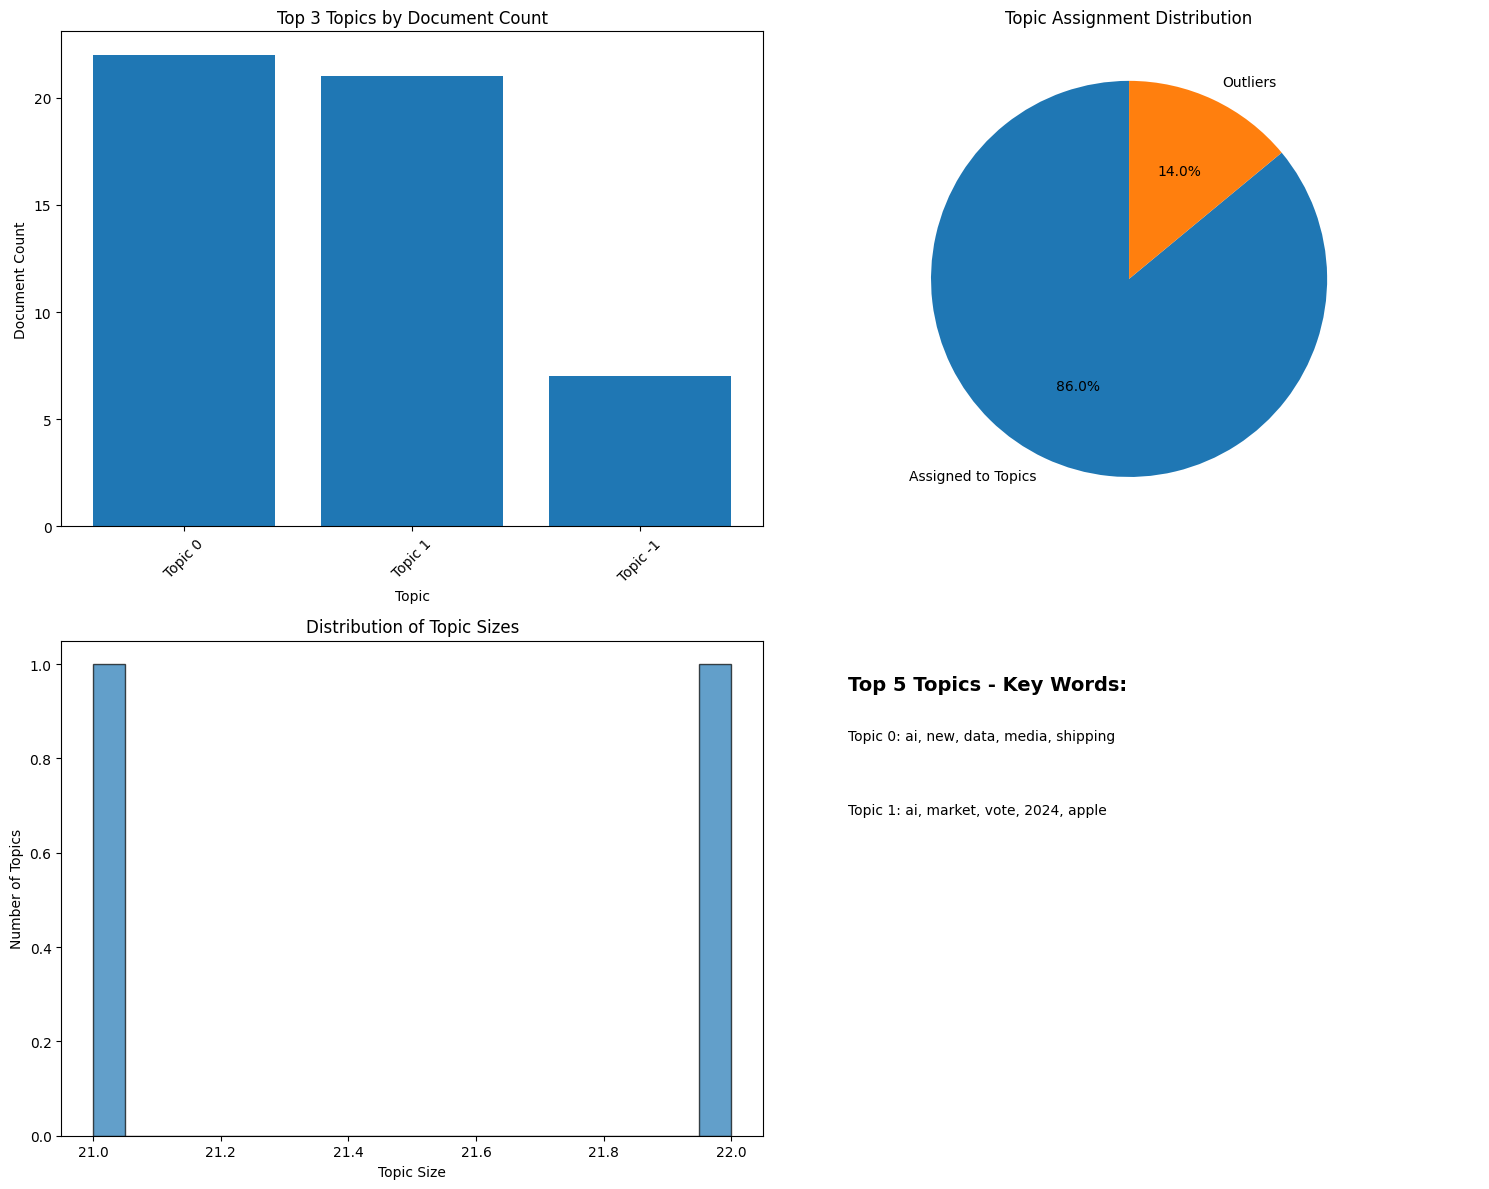


=== Testing Prediction on Validation Set ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-08-05 03:06:44,791 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-05 03:06:45,356 - BERTopic - Dimensionality - Completed ✓
2025-08-05 03:06:45,357 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-05 03:06:45,391 - BERTopic - Cluster - Completed ✓


Validation metrics:
coherence_score: 0.3781 (higher is better)
calinski_harabasz_score: 2.999
davies_bouldin_score: 1.623
num_topics: 2
outlier_percentage: 98.100
largest_topic_size: 22

=== Test run completed successfully! ===
You can now run with the full dataset by setting test_run=False


In [ ]:
# Test run on a small sample
trainer, metrics, topic_info = run_bertopic_workflow(df_relevant, sample_size=50, test_run=True)

In [ ]:
df_relevant.shape

(150466, 6)

=== BERTopic Modeling Workflow ===

Data split completed:
Training set: 108334 samples
Validation set: 12038 samples
Test set: 30094 samples

=== FULL RUN: Using complete training set (108334 documents) ===
Prepared 108334 documents for modeling


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-08-05 05:02:35,460 - BERTopic - Embedding - Transforming documents to embeddings.


Training BERTopic model on 108334 documents...


Batches:   0%|          | 0/3386 [00:00<?, ?it/s]

2025-08-05 05:06:05,090 - BERTopic - Embedding - Completed ✓
2025-08-05 05:06:05,091 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-05 05:08:55,349 - BERTopic - Dimensionality - Completed ✓
2025-08-05 05:08:55,353 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-05 05:09:02,197 - BERTopic - Cluster - Completed ✓
2025-08-05 05:09:02,224 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-05 05:12:50,200 - BERTopic - Representation - Completed ✓


Model training completed!
Number of topics discovered: 421
Number of outliers: 37604

=== Training Set Evaluation ===
coherence_score: 0.5464 (higher is better)
calinski_harabasz_score: 108.219
davies_bouldin_score: 2.831
num_topics: 421
outlier_percentage: 34.711
largest_topic_size: 37604


Batches:   0%|          | 0/377 [00:00<?, ?it/s]

2025-08-05 05:49:48,483 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-05 05:50:15,656 - BERTopic - Dimensionality - Completed ✓
2025-08-05 05:50:15,657 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-05 05:50:17,266 - BERTopic - Cluster - Completed ✓



=== Validation Set Evaluation ===
coherence_score: 0.5428 (higher is better)
calinski_harabasz_score: 12.133
davies_bouldin_score: 2.429
num_topics: 421
outlier_percentage: 38.420
largest_topic_size: 37604


Batches:   0%|          | 0/941 [00:00<?, ?it/s]

2025-08-05 05:55:42,307 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-05 05:55:59,154 - BERTopic - Dimensionality - Completed ✓
2025-08-05 05:55:59,154 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-05 05:56:03,085 - BERTopic - Cluster - Completed ✓



=== Test Set Evaluation (Final Performance) ===
coherence_score: 0.5464 (higher is better)
calinski_harabasz_score: 29.004
davies_bouldin_score: 2.716
num_topics: 421
outlier_percentage: 38.772
largest_topic_size: 37604

=== Topic Summary ===
     Topic  Count  Percentage  \
0        0   2100    1.938450   
1        1   1862    1.718759   
2        2   1672    1.543375   
3        3   1276    1.177839   
4        4   1128    1.041224   
..     ...    ...         ...   
416    416     50    0.046154   
417    417     50    0.046154   
418    418     50    0.046154   
419    419     50    0.046154   
420    420     50    0.046154   

                                                                                                                      Top_Words  
0    overviewview, entertain ment, entertain, ment media, consumer, products, transportation, general, ment, financial services  
1                             newswires, presswire, ein presswire, ein, distribution, virginia, car

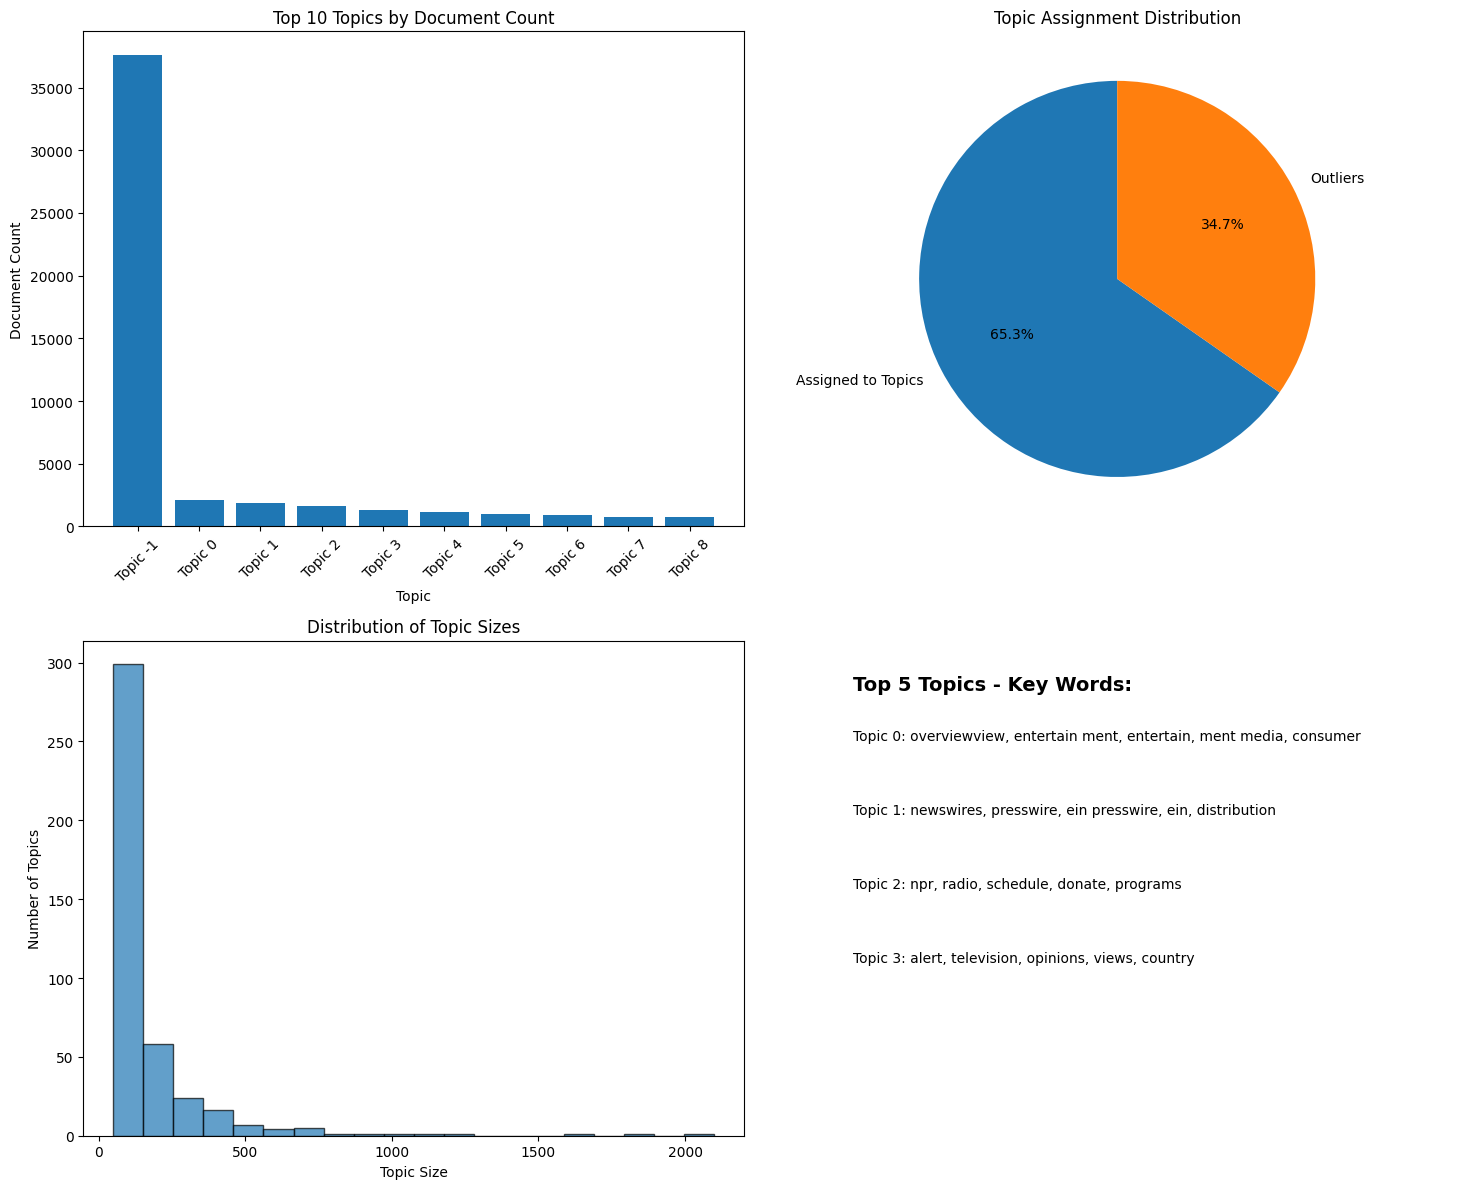

In [ ]:
# Full training after testing
trainer, metrics, topic_info = run_bertopic_workflow(df_relevant, test_run=False)


In [ ]:
print(topic_info['Top_Words'].iloc[:100])

0     overviewview, entertain ment, entertain, ment media, consumer, products, transportation, general, ment, financial services
1                              newswires, presswire, ein presswire, ein, distribution, virginia, carolina, north, south, pricing
2                                                      npr, radio, schedule, donate, programs, arts, listen, vehicle, 00, public
3                                           alert, television, opinions, views, country, weather, audio, provided, group, alerts
4                                                 altman, sam altman, sam, openai, board, ceo, microsoft, founder, return, chief
5                                                           nvidia, chips, chip, pc, hardware, mar, aug, gaming, performance, 11
6               automation, data, enterprise, generative ai, generative, management, employees, agents, analytics, organizations
7                                                       gpt, chatgpt, openai, users, gadgets, mod

In [ ]:
import pickle
import json

# Save trainer object using pickle
with open('bertopic_trainer.pkl', 'wb') as f:
    pickle.dump(trainer, f)

# Save metrics dictionary using json
with open('bertopic_metrics.json', 'w') as f:
    json.dump(metrics, f)

# Save topic_info DataFrame using parquet
topic_info.to_parquet('bertopic_topic_info.parquet')

print("Model results saved successfully!")

Model results saved successfully!


In [ ]:
topic_info = pd.read_parquet('bertopic_topic_info.parquet', engine='pyarrow')
topic_info.shape

(421, 5)

In [ ]:
print(topic_info['Top_Words'].iloc[100:201])

100                                   energy, power, climate, demand, gas, storage, required, infrastructure, data, center
101                                              finance, uae, ukraine, climate, provided, uk, asia, global, future, green
102                          english, overview, engineering, leaders, insights, explore, code, value, learn, organizations
103                                   hours ago, ago, hours, city, bestreviews, ago video, fox, weather, file, public file
104                            copyright, law, property, protection, court, works, united states, states, united, training
105                                  expert, journalists, science, cancer, live, meeting, pricing, request, women, experts
106                                              stock, trading, price, nasdaq, quarter, total, 00, earnings, insider, llc
107                                      green, projects, uae, saudi, capital, global, investment, africa, provided, trust
108             

**Intertopic Distance Map**

In [ ]:
def load_bertopic_with_custom_class(pickle_path):
    """
    Load BERTopic model with custom class definition
    """
    try:
        # Make sure the class is available in the current namespace
        globals()['BERTopicModelTrainer'] = BERTopicModelTrainer

        # Now try to load
        with open(pickle_path, 'rb') as f:
            trainer = pickle.load(f)
        print("✅ Successfully loaded BERTopicModelTrainer")

        # Extract the actual BERTopic model if it's wrapped
        if hasattr(trainer, 'model') and trainer.model is not None:
            bertopic_model = trainer.model
        elif hasattr(trainer, 'bertopic_model') and trainer.bertopic_model is not None:
            bertopic_model = trainer.bertopic_model
        else:
            bertopic_model = trainer  # In case the trainer itself is the model

        return trainer, bertopic_model

    except Exception as e:
        print(f"❌ Error loading with custom class: {e}")
        return None, None

In [ ]:
import pickle

# Load saved model
trainer, bertopic_model = load_bertopic_with_custom_class('drive/MyDrive/NLP/bertopic_trainer.pkl')

✅ Successfully loaded BERTopicModelTrainer


In [ ]:
bertopic_model.visualize_topics(top_n_topics=100)

## Assign Topics to Themes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

In [ ]:
topic_info = pd.read_parquet('drive/MyDrive/NLP/bertopic_topic_info.parquet', engine='pyarrow')
topic_info.shape

(421, 5)

In [ ]:
def map_topics_to_themes(topic_info_df):
    """
    Map BERTopic topics to predefined major themes based on keyword similarity.

    Args:
        topic_info_df: DataFrame with columns ['Topic', 'Count', 'Top_Words', 'Word_Scores', 'Percentage']

    Returns:
        DataFrame with additional 'Major_Theme' column
    """

    # Define major themes with their associated keywords
    theme_keywords = {
        "AI Technology and Development": [
            "ai", "artificial intelligence", "machine learning", "ml", "deep learning", "neural networks",
            "algorithms", "model", "models", "training", "gpt", "chatgpt", "openai", "technology",
            "development", "research", "innovation", "breakthrough", "advancement", "computing",
            "systems", "intelligence", "cognitive", "llm", "transformer", "bert", "altman", "nvidia",
            "meta", "chips", "musk", "amazon", "google", "demini", "cloud", "microsoft",
            "windows", "chatbot", "ai assistants", "pc", "hardware", "performance", "gpt",
            "model", "bard", "android", "galaxy"

        ],

        "AI in Enterprise and Automation": [
            "enterprise", "automation", "business", "corporate", "company", "workflow", "process",
            "efficiency", "productivity", "operations", "management", "organization", "industrial",
            "commercial", "b2b", "saas", "platform", "solution", "implementation", "deployment",
            "integration", "optimization", "analytics", "data", "generative ai", "data management",
            "cypersecurity", "customer service", "contact centers",
            "enterprise computing", "startups", "launches", "product", "week", "report",
            "reports", "launched"
        ],

        "AI in Creative and Media Industries": [
            "creative", "media", "content", "art", "design", "music", "audio", "video", "film",
            "entertainment", "graphics", "visual", "digital", "production", "studio",
            "artist", "creator", "copyright", "intellectual property", "streaming", "publishing",
            "journalism", "news", "broadcast", "television", "radio", "npr", "tv", "voice acting",
            "images", "ai-generated images", "creative content", "creative tools", "voice",
            "movie", "game", "television"
        ],

        "AI in Consumer Technology": [
            "consumer", "users", "user", "personal", "mobile", "app", "smartphone", "device",
            "gadgets", "smart", "home", "assistant", "voice", "alexa", "siri", "google",
            "android", "ios", "interface", "experience", "ux", "ui", "accessibility",
            "apple", "iphone", "devices", "samsung", "galaxy", "phone", "phones",
            "smart devices", "whatsapp", "electronics", "pro", "devices","smartphones",
            "games", "gaming", "game", "pc", "players"
        ],

        "AI in Finance and Cryptocurrency": [
            "finance", "financial", "banking", "investment", "trading", "crypto", "cryptocurrency",
            "bitcoin", "blockchain", "fintech", "payment", "transaction", "market", "economy",
            "economic", "stock", "portfolio", "risk", "fraud", "security", "compliance",
            "financial services", "stocks", "earnings", "ai in finance", "nasdaq", "markets",
            "price", "investors", "investor", "prices", "mining", "currencies"
        ],

        "AI in Healthcare": [
            "healthcare", "health", "medical", "medicine", "clinical", "patient", "diagnosis",
            "treatment", "therapy", "drug", "pharmaceutical", "hospital", "doctor", "physician",
            "nurse", "care", "wellness", "fitness", "mental health", "research", "biotech",
            "medical care", "cancer", "medical research", "early detection", "medical chatbots",
            "covid-19", "covid19"
        ],

        "AI Regulation and Governance": [
            "regulation", "policy", "government", "governance", "law", "legal", "compliance",
            "ethics", "ethical", "bias", "fairness", "transparency", "accountability", "privacy",
            "data protection", "gdpr", "legislation", "regulatory", "oversight", "standards",
            "guidelines", "framework", "safety", "security", "risk management", "federal",
            "eu", "ai act", "legal compliance", "ai safety", "white", "house", "global", "summit",
            "order", "biden", "trump", "laws", "risk", "regulations", "act"
        ],

        "AI in Education": [
            "education", "educational", "learning", "student", "teacher", "school", "university",
            "college", "academic", "curriculum", "training", "skills", "knowledge", "classroom",
            "online learning", "e-learning", "mooc", "tutoring", "assessment", "personalized learning",
            "students", "learning tools", "skills", "ai in education"
        ],

        "Regional and Global AI Adoption": [
            "global", "international", "regional", "country", "nation", "china", "usa", "europe",
            "asia", "adoption", "deployment", "implementation", "market", "growth", "expansion",
            "competition", "leadership", "strategy", "partnership", "india",
            "singapore", "uae", "saudi", "south korea", "russia", "south africa", "africa",
            "europe", "indian", "delhi", "government", "arabia", "middle east", "east",
            "european"
        ],

        "AI in Energy, Climate, and Infrastructure": [
            "energy", "climate", "environment", "sustainability", "green", "renewable", "solar",
            "wind", "power", "grid", "infrastructure", "smart grid", "utilities", "carbon",
            "emissions", "efficiency", "optimization", "weather", "forecasting", "infrastructure"
        ],

        "AI in Transportation (Vehicles and Automobile)": [
            "transportation", "transport", "vehicle", "car", "automobile", "automotive", "driving",
            "autonomous", "self-driving", "tesla", "mobility", "traffic", "logistics", "delivery",
            "shipping", "fleet", "navigation", "gps", "ride-sharing", "uber", "lyft", "vehicles",
            "automotive", "engineering"
        ],

        "AI in Military": [
            "military", "defense", "warfare", "weapon", "security", "surveillance", "intelligence",
            "national security", "army", "navy", "air force", "combat", "strategy", "tactical",
            "drone", "cybersecurity", "threat", "protection"
        ],

        "AI in Retail and Manufacturing": [
            "retail", "manufacturing", "production", "factory", "supply chain", "inventory",
            "customer", "shopping", "e-commerce", "sales", "marketing", "recommendation",
            "personalization", "quality control", "predictive maintenance", "robotics", "warehouse"
        ],

        "AI in Agriculture": [
            "agriculture", "farming", "crop", "livestock", "precision agriculture", "agtech",
            "food", "harvest", "yield", "soil", "irrigation", "fertilizer", "pesticide",
            "sustainability", "rural", "farmer"
        ]
    }

    def calculate_theme_similarity(top_words, theme_keywords_dict):
        """Calculate similarity between topic words and theme keywords."""

        # Clean and preprocess top_words
        if isinstance(top_words, str):
            # Remove brackets and quotes, split by comma
            words = re.sub(r'[\[\]\'"]', '', top_words).split(', ')
            words = [word.strip().lower() for word in words if word.strip()]
        else:
            words = []

        topic_text = ' '.join(words)

        # Calculate similarity with each theme
        similarities = {}

        for theme_name, keywords in theme_keywords_dict.items():
            theme_text = ' '.join(keywords)

            # Use TF-IDF vectorizer for better similarity calculation
            vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

            try:
                tfidf_matrix = vectorizer.fit_transform([topic_text, theme_text])
                similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
                similarities[theme_name] = similarity
            except:
                # Fallback to simple keyword matching
                matches = sum(1 for keyword in keywords if keyword.lower() in topic_text.lower())
                similarities[theme_name] = matches / len(keywords) if keywords else 0

        return similarities

    def assign_theme(top_words, threshold=0.1):
        """Assign a theme to a topic based on similarity scores."""
        similarities = calculate_theme_similarity(top_words, theme_keywords)

        if not similarities:
            return "Miscellaneous"

        # Find the theme with highest similarity
        best_theme = max(similarities, key=similarities.get)
        best_score = similarities[best_theme]

        # Apply threshold - if similarity is too low, classify as miscellaneous
        if best_score < threshold:
            return "Miscellaneous"

        return best_theme

    # Create a copy of the dataframe
    result_df = topic_info_df.copy()

    # Apply theme mapping
    result_df['Major_Theme'] = result_df['Top_Words'].apply(assign_theme)

    return result_df

def analyze_theme_distribution(mapped_df):
    """Analyze and display the distribution of topics across themes."""

    theme_stats = mapped_df.groupby('Major_Theme').agg({
        'Count': 'sum',
        'Percentage': 'sum',
        'Topic': 'count'
    }).rename(columns={'Topic': 'Number_of_Topics'})

    theme_stats = theme_stats.sort_values('Count', ascending=False)
    theme_stats['Avg_Topic_Size'] = theme_stats['Count'] / theme_stats['Number_of_Topics']

    return theme_stats

def manual_theme_assignment(mapped_df, topic_id, new_theme):
    """Manually assign a specific topic to a different theme."""
    mapped_df.loc[mapped_df['Topic'] == topic_id, 'Major_Theme'] = new_theme
    return mapped_df

In [ ]:
mapped_df = map_topics_to_themes(topic_info)

mapped_df.to_csv('topic_themes.csv', index=False)

from google.colab import files
files.download('topic_themes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
theme_stats = analyze_theme_distribution(mapped_df)
print(theme_stats)

                                     Count  Percentage  Number_of_Topics  \
Major_Theme                                                                
Miscellaneous                        58702   54.186128               381   
AI in Enterprise and Automation       1865    1.721528                 4   
AI in Education                       1742    1.607990                12   
AI Technology and Development         1619    1.494452                 3   
AI in Finance and Cryptocurrency      1564    1.443683                 5   
AI in Creative and Media Industries   1418    1.308915                 2   
AI Regulation and Governance          1139    1.051378                 2   
Regional and Global AI Adoption       1014    0.935994                 2   
AI in Consumer Technology             1004    0.926764                 5   
AI in Healthcare                       562    0.518766                 4   
AI in Military                         101    0.093230                 1   

           

### Major Topics Summariziation (Based on the First 100 Topics)

1. AI Technology and Development

  Key Topics:

  Topic 4 (Altman, OpenAI, Microsoft), Topic 5 (NVIDIA, chips, hardware), Topic 7 (ChatGPT, GPT, OpenAI), Topic 8 (AI systems, human intelligence, risks), Topic 21 (machine learning, data science, analytics), Topic 22 (Google Bard, chatbots), Topic 24 (Google, Gemini, generative AI), Topic 37 (Gemini, Google Assistant), Topic 41 (Amazon, cloud, generative AI), Topic 49 (Microsoft, Windows, chatbot), Topic 52 (OpenAI, Microsoft, funding), Topic 53 (Musk, OpenAI, Altman), Topic 87 (generative AI, creative tools). Topics 119 (Meta, open-source models), 123 (NVIDIA, chips, China), 133 (AI models, chatbots), 163 (Musk, AI risks), 181 (gadgets, AI assistants), 182 (ChatGPT, language models), 195 (Meta, AI assistants).

  Summary: A significant portion of the dataset focuses on advancements in AI technologies, particularly large language models (e.g., ChatGPT, Google Bard, Gemini), generative AI, and hardware (e.g., NVIDIA chips). Companies like OpenAI, Microsoft, Google, and Amazon are central, with emphasis on leadership (e.g., Sam Altman, Elon Musk), funding, and model development. The new topics reinforce AI’s technological core, with Meta emerging as a significant player through open-source models and AI assistants (e.g., WhatsApp integration). NVIDIA’s role in chip development is further highlighted, particularly in geopolitical contexts (e.g., U.S.-China chip restrictions). Generative AI is a prominent subtheme, appearing in contexts like creative tools, cloud services, and enterprise solutions. Discussions also include risks and ethical considerations of AI systems, such as their impact on human intelligence and potential misuse.

2. AI in Enterprise and Automation

  Key Topics:

  Topic 6 (automation, enterprise, data management), Topic 10 (cybersecurity, data privacy), Topic 26 (banking, financial services, automation), Topic 45 (customer service, generative AI), Topic 59 (customer service, sales, contact centers), Topic 74 (management, enterprise computing). Topics 113 (startups, funding), 134 (storage, cloud, security), 173 (banking, transformation), 183 (productivity, AI agents).

  Summary: AI is extensively covered in enterprise settings, focusing on automation, data analytics, and customer service enhancements. Topics highlight AI’s role in improving operational efficiency, managing data, and enhancing cybersecurity and compliance. Generative AI is noted for transforming customer service through virtual agents and personalized experiences. New topics emphasize AI’s role in startups (Topic 113) and productivity tools (Topic 183), highlighting AI-driven automation in smaller enterprises and team workflows. Cloud infrastructure and security (Topic 134) further underscore AI’s enterprise integration.

3. AI in Creative and Media Industries

  Key Topics:

  Topic 9 (music, audio, copyright), Topic 13 (film, TV, voice acting), Topic 40 (art, design, images), Topic 42/44/61 (AI-generated images, creative content), Topic 87 (generative AI, creative tools), Topic 93 (AI-generated images, ethical concerns). Topics 104 (copyright, legal issues), 142 (voice, music), 152 (video, content generation), 193 (AI-generated images).

  Summary: AI’s role in creative industries is a major focus, particularly in music, film, and visual arts. Generative AI is used for creating audio, images, and videos, raising concerns about copyright, ethics, and authenticity (e.g., lawsuits involving OpenAI and media outlets). AI’s impact on voice acting and content creation is also highlighted. The new topics strengthen the focus on copyright and legal issues (Topic 104) and expand into video and audio generation (Topic 152). Ethical concerns about AI-generated content remain prominent.

4. AI in Consumer Technology

  Key Topics:

  Topic 16 (Apple, iPhone, devices), Topic 23 (Samsung, Galaxy, phones), Topic 27 (gaming, mobile), Topic 97 (Samsung, Apple, gadgets). Topics 129 (WhatsApp, Meta, chatbots), 135 (Google, Android), 161 (Samsung, electronics), 195 (Meta, smart devices).

  Summary: AI is integrated into consumer devices like smartphones (e.g., iPhone, Galaxy) and gaming platforms, enhancing features like cameras, voice assistants, and user interfaces. Meta’s AI integration into consumer platforms like WhatsApp (Topic 129) and smart devices (Topic 195) adds a new dimension to consumer tech. Samsung’s role in smart devices (Topic 161) complements Apple and Google’s efforts. These topics reflect AI’s role in improving user experiences in consumer electronics.

5. AI in Finance and Cryptocurrency

  Key Topics:

  Topic 17 (Bitcoin, blockchain, crypto), Topic 26 (banking, financial services), Topic 34 (crypto trading, investment), Topic 55 (crypto prices, trading), Topic 60 (stocks, investors), Topic 84 (stock market, investing), Topic 86 (stocks, earnings). Topics 106 (stock trading), 131 (oil, stocks), 141 (stock, earnings), 169 (stock trading), 170 (AI in finance), 178 (crypto, trading).

  Summary: AI is deeply integrated into financial markets, particularly in cryptocurrency trading, stock analysis, and investment strategies. Blockchain and crypto platforms leverage AI for price prediction and portfolio management, while traditional finance uses AI for automation and risk management. The additional topics solidify AI’s role in stock trading, market analysis, and cryptocurrency, with a focus on real-time trading and financial forecasting.

6. AI in Healthcare

  Key Topics:

  Topic 48 (healthcare, medical care), Topic 64 (cancer, medical research), Topic 69 (cancer, early detection). Topics 105 (cancer, medical experts), 157 (medical chatbots), 162 (cancer, COVID-19), 177 (healthcare market).

  Summary: AI is transforming healthcare through applications in medical diagnostics (e.g., cancer detection), patient care, and research. It improves accuracy in diagnostics and supports data-driven medical insights. New topics highlight AI’s role in medical research (e.g., cancer studies) and chatbots for healthcare delivery (Topic 157). Market growth (Topic 177) underscores AI’s economic impact in healthcare.
  
7. AI Regulation and Governance

  Key Topics:

  Topic 14 (India, governance), Topic 19 (federal, executive orders), Topic 30 (EU, AI Act, regulation), Topic 57 (United States, legal compliance), Topic 85 (AI safety, global summits). Topics 104 (copyright law), 160 (UK regulation), 164 (legal cases), 196 (global governance).

  Summary: Regulatory frameworks and governance are significant, with focus on the EU’s AI Act, U.S. executive orders, and global safety summits. Discussions emphasize balancing innovation with risk mitigation and ethical considerations.

8. AI in Education

  Key Topics:

  Topic 58 (students, ChatGPT, education), Topic 66 (education, learning tools). Topics 118 (students, university), 186 (education, skills).

  Summary: AI tools like ChatGPT are used in education for writing assistance and personalized learning, raising concerns about academic integrity and skill development. The focus on education is consistent, with new topics emphasizing student use of AI tools and skill development for future job markets.

9. Regional and Global AI Adoption

  Key Topics:

  Topic 12 (Africa, digital economy), Topic 14 (India, innovation), Topic 29 (UAE, Saudi Arabia), Topic 31 (Singapore, Asia), Topic 38 (China, military), Topic 65 (China, AI models). Topics 101 (UAE, climate), 107 (UAE, Saudi, investment), 127 (South Korea), 148 (South Africa, Russia), 166 (Singapore, investment).

  Summary: AI adoption varies by region, with India focusing on innovation, the Middle East on economic diversification, and China on military and technological advancements. Africa and Singapore emphasize digital transformation. New topics highlight AI investment in regions like the UAE, South Korea, and Singapore, with a focus on economic and infrastructural development.

10. AI in Energy, Climate, and Infrastructure
  Key Topics: Topics 100 (energy, climate), 101 (climate, green tech), 107 (green projects), 111 (climate, machine learning), 156 (5G, infrastructure).

  The new topics introduce a strong focus on AI’s role in energy, climate solutions, and infrastructure (e.g., 5G networks, data centers). Machine learning for climate modeling (Topic 111) and green projects (Topic 107) are notable additions.


11. Miscellaneous and Emerging Topics

  Key Topics:

  Topic 18 (automotive, vehicles), Topic 51 (manufacturing, retail), Topic 63 (Israel, military), Topic 95 (climate, agriculture).

  Summary: AI applications extend to automotive (self-driving cars), manufacturing, retail, military, and climate-focused agriculture, indicating its broad societal impact.

### Industry Connections

Technology Sector: AI development is heavily tied to tech giants (OpenAI, Microsoft, Google, NVIDIA, Amazon), focusing on cloud computing, hardware (chips), and software (chatbots, generative models). <br>
Jobs: Roles in AI engineering, data science, machine learning, hardware engineers, ethical AI specialists, and cloud architecture are prominent, with a demand for skills in model development, deployment, and optimization. Open-source AI (Topic 119) suggests roles in community-driven development and integration.

Finance and Banking: AI automates risk assessment, compliance, and customer interactions (e.g., chatbots in banking). <br>
Customer Service: AI-driven virtual agents and analytics are reshaping call centers and service industries. <br>
Cybersecurity: AI is integral to threat detection, data protection, and privacy compliance. <br>
Jobs: Demand for roles like data analysts, startup founders, cloud architects, cybersecurity specialists, enterprise AI architects, automation specialists, productivity tool developers, and customer experience managers is evident.


Entertainment and Media: AI generates music, scripts, and visuals, impacting film, TV, and gaming industries.
Legal: Copyright disputes and ethical concerns about AI-generated content are prominent. <br>
Jobs: Roles like content creators, AI ethicists, and legal professionals specializing in IP are affected, alongside creative professionals adapting to AI tools, and creative professionals skilled in AI tools continues to rise.

Consumer Electronics: AI drives innovation in smartphones, wearables, and gaming hardware.
Gaming: AI enhances game development and player experiences through procedural content generation and NPC behavior. <br>
Jobs: Demand for mobile app developers, UI/UX designers, and embedded AI engineers is growing. Roles in consumer AI integration, chatbot development, and smart device engineering are expanding.

Finance: AI supports trading algorithms, fraud detection, and financial forecasting.
Cryptocurrency: AI enhances blockchain analytics and trading platforms. <br>
Jobs: Roles like financial analysts, algorithmic traders, crypto platform developers, and blockchain developers are impacted.

Healthcare: AI aids in diagnostics, treatment planning, and patient monitoring. <br>
Jobs: Roles like medical data scientists, health chatbot developers, health informatics specialists, healthcare AI consultants, and AI-driven diagnostic tool developers are emerging.

Government and Policy: AI regulation shapes industry practices and compliance requirements. <br>
Jobs: Policy analysts, AI ethicists, legal advisors specializing in AI regulation, and compliance officers are increasingly relevant.


Education: AI enhances e-learning platforms and tutoring systems. <br>
Jobs: Educators, edtech developers, AI literacy educators, and academic integrity specialists are impacted.


Global Markets: AI drives economic growth and competitiveness across regions. <br>
Jobs: Regional AI strategists, policy advisors, investment analysts, and localized AI developers are in demand.


Industry: AI is critical for optimizing energy systems, climate modeling, and infrastructure development (e.g., smart grids, 5G networks). <br>
Jobs: Roles in climate tech, energy analytics, and infrastructure AI engineering are emerging.


Automotive and Manufacturing: AI optimizes production and autonomous systems. <br>
Military: AI enhances defense strategies and surveillance. <br>
Agriculture: AI supports sustainable practices and resource management. <br>
Jobs: Engineers in autonomous systems, manufacturing analysts, and climate tech specialists are relevant.